In [11]:
## Import Packages
from __future__ import print_function

import numpy as np
import pandas as pd
from itertools import product

#Astro Software
import astropy.units as units
from astropy.coordinates import SkyCoord
from astropy.io import fits

#Plotting Packages
import matplotlib as mpl
import matplotlib.cm as cmplt
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns

from PIL import Image, ImageDraw

from yt.config import ytcfg
import yt
from yt.analysis_modules.ppv_cube.api import PPVCube
import yt.units as u

#Scattering NN
import torch
import torch.nn.functional as F
from torch import optim
from kymatio.torch import Scattering2D
device = "cpu"

#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import skimage
from skimage import filters
from skimage.filters import window

from scipy.optimize import curve_fit
from scipy import linalg
from scipy import stats
from scipy.signal import general_gaussian
from scipy.ndimage import map_coordinates

# from scipy.sparse import csr_matrix
from scipy.sparse import csc_matrix
from scipy.sparse.csgraph import reverse_cuthill_mckee

#I/O
import h5py
import pickle
import glob
import copy
import time
import os
#from bs4 import BeautifulSoup
import scipy.io as sio

#Plotting Style
%matplotlib inline
plt.style.use('dark_background')
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 20
rcParams['font.family'] = 'sans-serif'

#Threading
torch.set_num_threads=2
from multiprocessing import Pool

import ntpath
def path_leaf(path):
    head, tail = ntpath.split(path)
    out = os.path.splitext(tail)[0]
    return out

def hd5_open(file_name,name):
    f=h5py.File(file_name,'r', swmr=True)
    data = f[name][:]
    f.close()
    return data

from matplotlib.colors import LinearSegmentedColormap
cdict1 = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 0.0, 1.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }
blue_red1 = LinearSegmentedColormap('BlueRed1', cdict1,N=5000)
import colorcet

[WARNING]: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions. (FutureWarning)


mean total resid 0.0067254591521643215


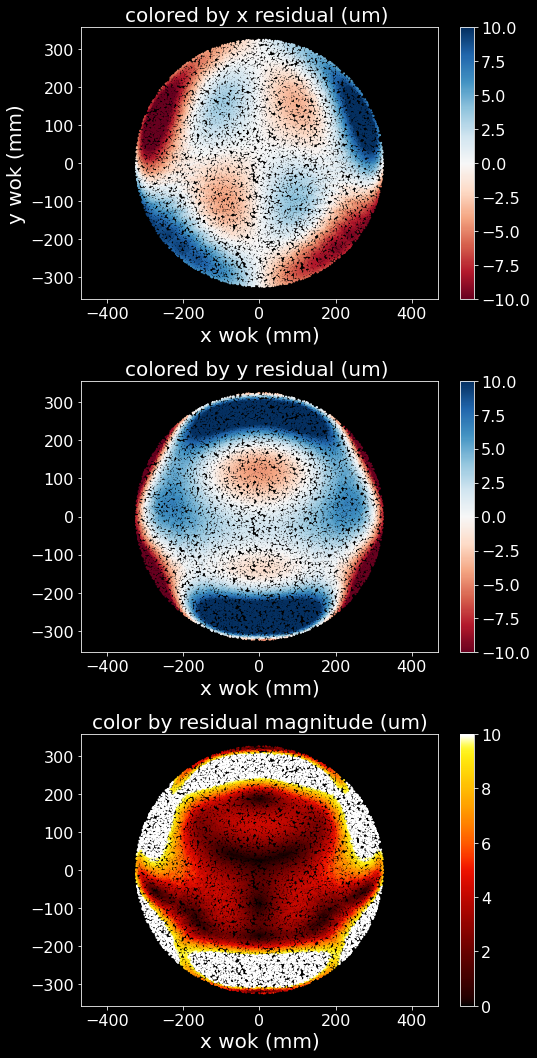

In [12]:
import numpy
import pandas as pd
from coordio import zernike
from skimage.transform import SimilarityTransform
import matplotlib.pyplot as plt

apoDF = pd.read_csv("../scratch/allapo.csv", index_col=0)

# fiducials used for training
trainSet = apoDF[apoDF.fiducial == True]
trainMeas = trainSet[["fvcX", "fvcY"]].to_numpy()
trainExpect = trainSet[["fpX", "fpY"]].to_numpy()

# other points used for testing
# these are slightly within the max radius of the fiducials
testSet = apoDF[apoDF.fiducial == False]
testMeas = testSet[["fvcX", "fvcY"]].to_numpy()
testExpect = testSet[["fpX", "fpY"]].to_numpy()


# first fits trans/rot/scale transform to roughly put
# CCD xy (pixels) into xy focal plane (mm)
transRotScaleModel = SimilarityTransform()
transRotScaleModel.estimate(trainMeas, trainExpect)

# apply trans/rot/scale fit
trainSimFit = transRotScaleModel(trainMeas)
testSimFit = transRotScaleModel(testMeas)

# zernike radial order selected from cross validation from previous analysis
zernRadOrder = 8

# zernikes are defined only on unit disk
# determine max radius of inputs to scale by
max1 = numpy.max(numpy.linalg.norm(trainSimFit, axis=1))
max2 = numpy.max(numpy.linalg.norm(testSimFit, axis=1))
maxRadFP = numpy.max([max1, max2])

zf = zernike.ZernFit(
    trainSimFit[:, 0], trainSimFit[:, 1], trainExpect[:, 0], trainExpect[:, 1],
    orders=zernRadOrder, method="grad", scaleR=maxRadFP
)

# fitting is done, now apply trans/rot/scale fit to test data


# determine zernike "residual" adjustment to add to the testSimFit
xFit, yFit = zf.apply(testSimFit[:,0], testSimFit[:,1])

xResid = testExpect[:,0] - xFit
yResid = testExpect[:,1] - yFit
totalResid = numpy.sqrt(xResid**2 + yResid**2)
print("mean total resid", numpy.mean(totalResid))

fig, axs = plt.subplots(3,1, figsize=(8,18))

# labels = ["xResid (true-pred)", "yResid (true-pred)", "xyResid sqrt(xResid^2+yResid^2)"]
labels = ["colored by x residual (um) ", "colored by y residual (um) ", "color by residual magnitude (um)"]
i = 0
vmin = -10
vmax = 10
cmap = "RdBu"
for label, resid in zip(labels, [xResid,yResid,totalResid]):
    # plt.figure()
    ax = axs[i]
    ax.set_title(label)
    im = ax.scatter(testExpect[:, 0], testExpect[:, 1], s=1, c=resid*1000, vmin=vmin, vmax=vmax, cmap=cmap)
    # ax.colorbar(label="micron")
    ax.axis("equal")
    ax.set_xlabel("x wok (mm)")
    if i == 0:
        ax.set_ylabel("y wok (mm)")
    plt.colorbar(im, ax=ax)
    if i == 1:
        vmin = 0
        cmap = "cet_fire"
    i += 1

plt.subplots_adjust(hspace=0.3, wspace=0.1)
plt.savefig("zernResids.png", dpi=350)
plt.show()

In [13]:
apoDF = pd.read_csv("../scratch/allapo.csv", index_col=0)

# fiducials used for training
trainSet = apoDF[apoDF.fiducial == True]
trainMeas = trainSet[["fvcX", "fvcY"]].to_numpy()
trainExpect = trainSet[["fpX", "fpY"]].to_numpy()

# other points used for testing
# these are slightly within the max radius of the fiducials
testSet = apoDF[apoDF.fiducial == False]
testMeas = testSet[["fvcX", "fvcY"]].to_numpy()
testExpect = testSet[["fpX", "fpY"]].to_numpy()

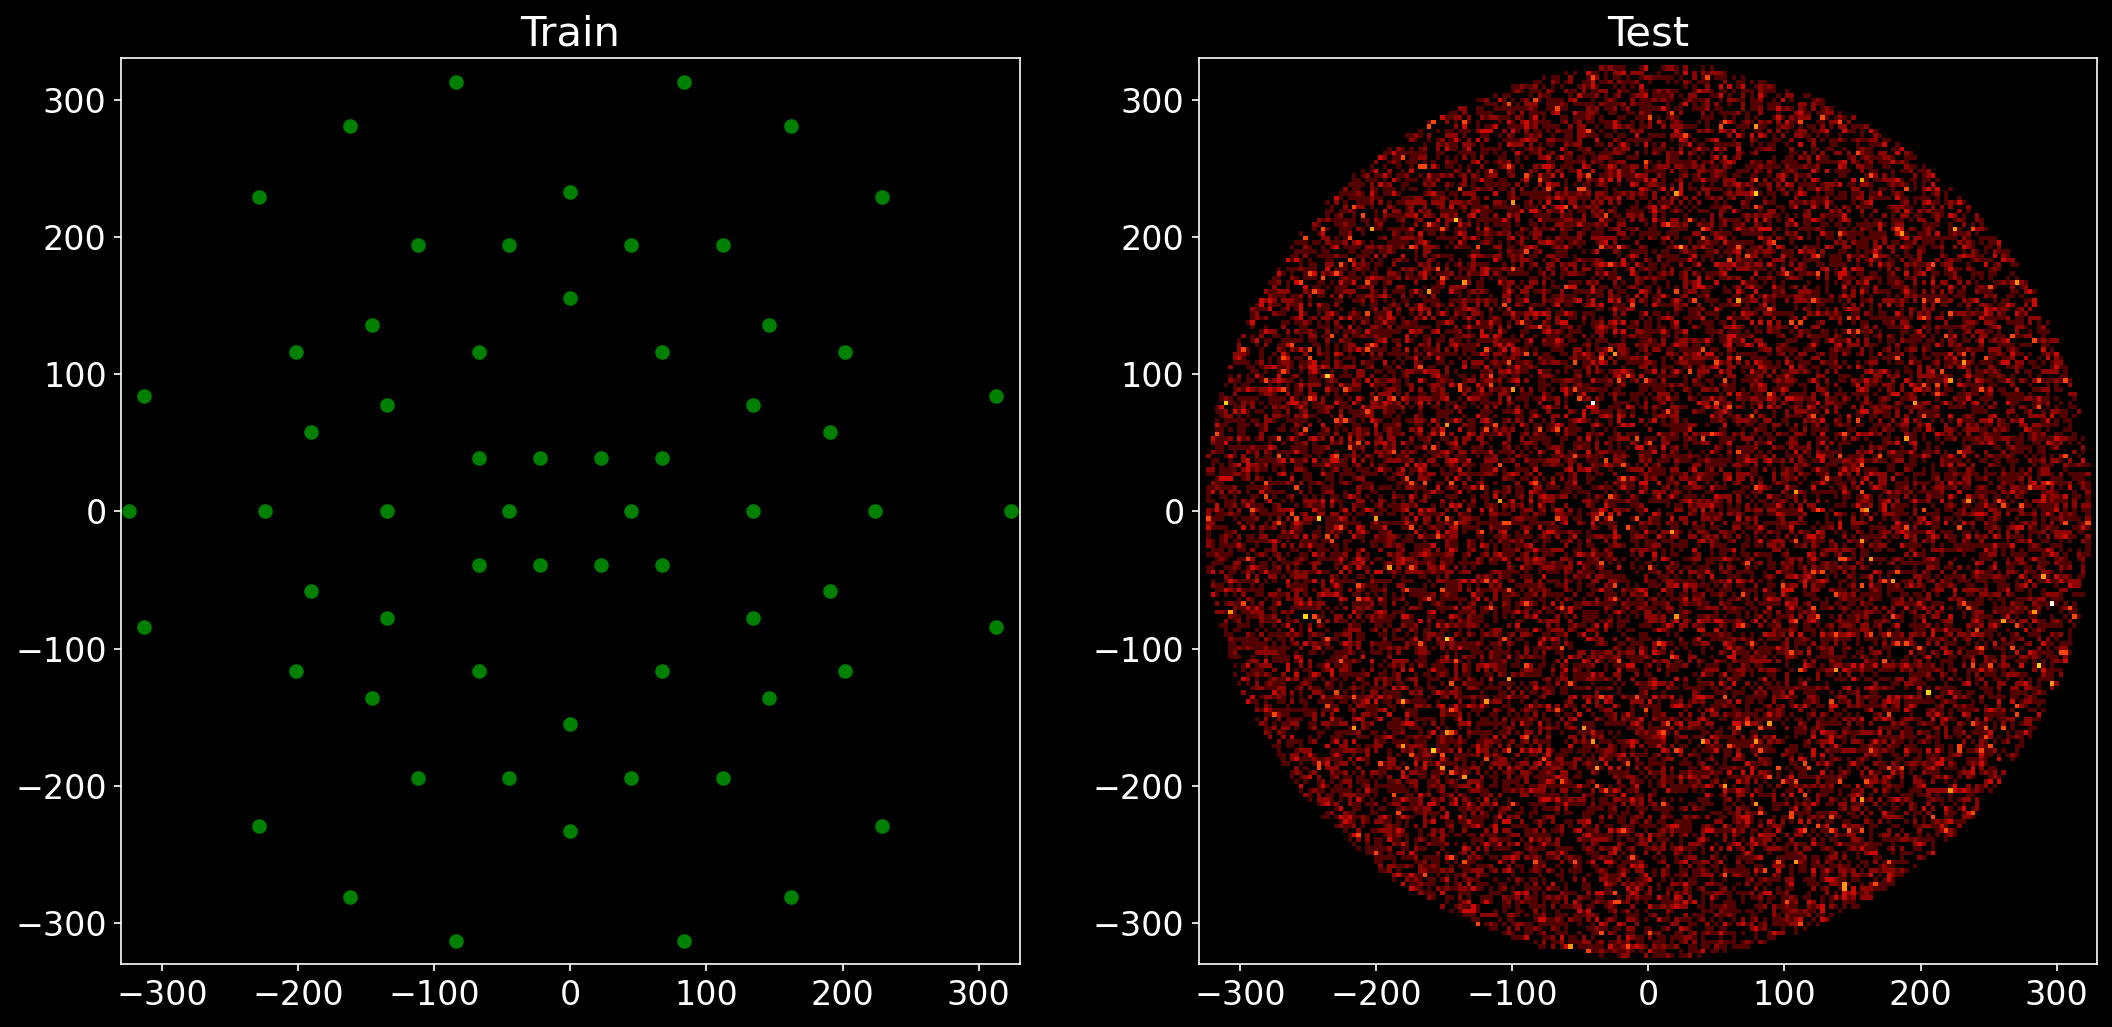

In [50]:
fig = plt.figure(figsize=(17,8), dpi=150)

ax = fig.add_subplot(1,2,1)
ax.scatter(trainExpect[:,0],
    trainExpect[:,1],
    c='g'
)
ax.set_xlim([-330,330])
ax.set_ylim([-330,330])
ax.set_title("Train")

ax = fig.add_subplot(1,2,2)
ax.hist2d(testExpect[:,0],
    testExpect[:,1],
    bins=200,
    cmap="cet_fire",
)
ax.set_xlim([-330,330])
ax.set_ylim([-330,330])
ax.set_title("Test")


fig.subplots_adjust(wspace=0.2, hspace=0)

In [36]:
min(trainExpect[:,0])

-324.0